#### Importing necessary libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
from subprocess import check_output

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#### Loading the data

In [8]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

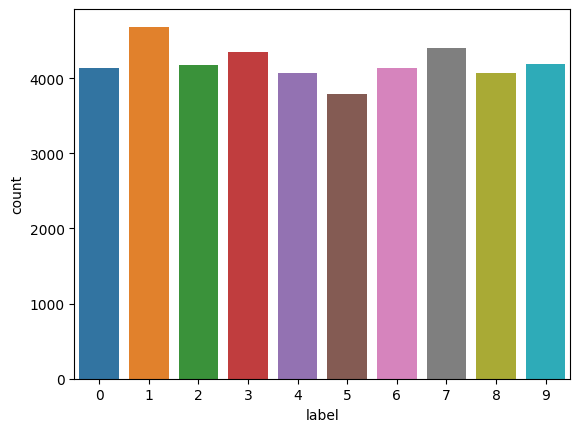

In [12]:
sns.countplot(x=train['label'])
plt.show()

In [13]:
test= pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
x_train = (train.iloc[:, 1:].values).astype('float32')  # all pixel values except the first column
y_train = train.iloc[:, 0].values.astype('int32')  # only labels i.e., target digits
x_test = test.values.astype('float32')  # test data has no label column

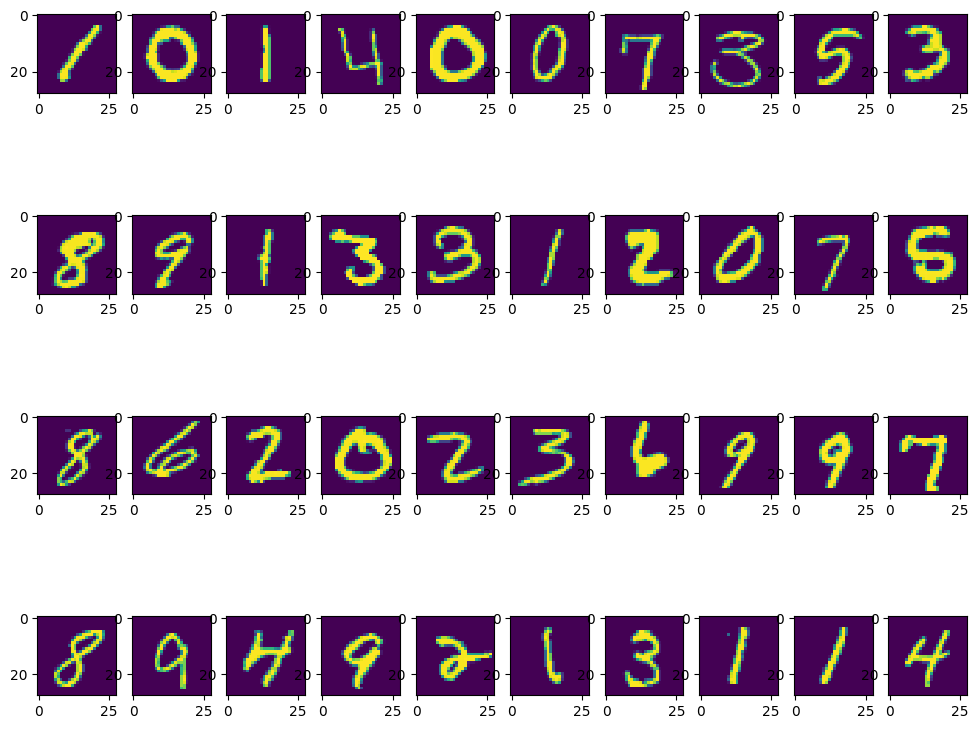

In [16]:
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

#### Normalizing the data

In [17]:
x_train = x_train/255.0
x_test = x_test/255.0

In [19]:
print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 784)
42000 train samples
28000 test samples


#### Reshaping the data to match keras's expectations

In [20]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

In [24]:
batch_size = 64
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)

#### One Hot Encoding - Converting class vectors to binary class matrices

In [25]:
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

#### Model

In [26]:
#Linear model
model = Sequential()

#Adding layers to the model
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

#Compiling the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

#Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### Data Augmentation

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 730,602 (2.79 MB)

 Trainable params: 730,346 (2.79 MB)

 Non-trainable params: 256 (1.00 KB)

In [30]:
datagen.fit(X_train)

model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                            epochs = epochs, validation_data = (X_val,Y_val),
                            verbose = 1, steps_per_epoch=X_train.shape[0],
                            callbacks=[learning_rate_reduction])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  591/37800 ━━━━━━━━━━━━━━━━━━━━ 1:23:05 134ms/step - accuracy: 0.7648 - loss: 0.7297

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


37800/37800 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - accuracy: 0.8840 - loss: 0.3657 - val_accuracy: 0.9824 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


37800/37800 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9646 - loss: 0.1152 - val_accuracy: 0.9874 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 3/20
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9740 - loss: 0.0864 - val_accuracy: 0.9902 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 4/20
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9785 - loss: 0.0722 - val_accuracy: 0.9917 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 5/20
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9797 - loss: 0.0654 - val_accuracy: 0.9888 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 6/20
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9823 - loss: 0.0583 - val_accuracy: 0.9886 - val_loss: 0.0416 - learning_rate: 0.0010
Epoch 7/20
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 141s 2ms/step - accuracy: 0.9840 - loss: 0.0523 - val_accuracy: 0.9921 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 8/20
37800/37800 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy:

#### Model Evaluation

In [31]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.019303, final accuracy: 0.993333


132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


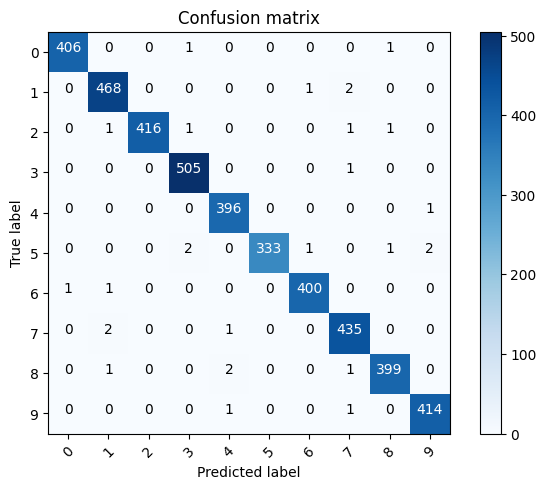

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(Y_val, axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10))